[IPython Notebook](apsidal_motion.ipynb) |  [Python Script](apsidal_motion.py)

Apsidal Motion
============================

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new Bundle.  See [Building a System](building_a_system.html) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/usr/local/lib/python2.7/dist-packages/astropy/units/quantity.py:732: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


In order for apsidal motion to be apparent, we need an eccentric system that is precessing.

In [3]:
b['ecc'] = 0.2

Let's set a very noticeable rate of precession.

In [4]:
b['dperdt'] = 2.0 * u.deg/u.d

We'll add lc, orb, and etv datasets to see how the apsidal motion affects each.  We'll need to sample over several orbits of the binary (which has a period of 3 days, by default).

In [5]:
b.add_dataset('lc', times=np.linspace(0,1,101), dataset='lc01')
b.add_dataset('lc', times=np.linspace(4,5,101), dataset='lc02')

<ParameterSet: 15 parameters | contexts: compute, dataset>

In [6]:
b.add_dataset('orb', times=np.linspace(0,5,401), dataset='orb01')

<ParameterSet: 3 parameters | contexts: compute, dataset>

In [7]:
#b.add_dataset('etv', Ns=np.arange(0,5,1), dataset='etv01')

In [8]:
b.run_compute(irrad_method='none')

<ParameterSet: 18 parameters | kinds: orb, lc>

Influence on Oribits (positions)
-----------------

Let's plot the orbit from above and highlight the positions of each star at each cycle (times that are multiples of the period).

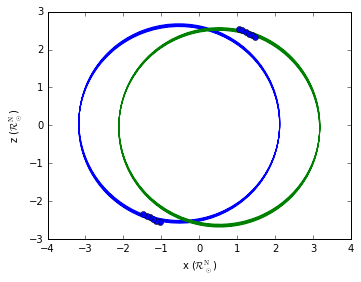

In [8]:
axs, artists = b['orb01@model'].plot(y='zs', time=[0,1,2,3,4,5])

Influence on Light Curves (fluxes)
-------------------

Now looking at the light curve, we can see that this is resulting in the eclipses moving in phase-space.

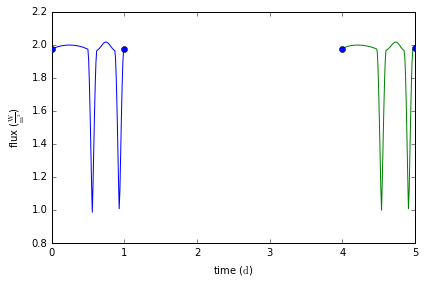

In [9]:
axs, artists = b['lc01@model'].plot(time=[0,1])
axs, artists = b['lc02@model'].plot(time=[4,5]) 
#axs, artists = b['etv01@model'].plot(x='time_ecls', y=0.23)

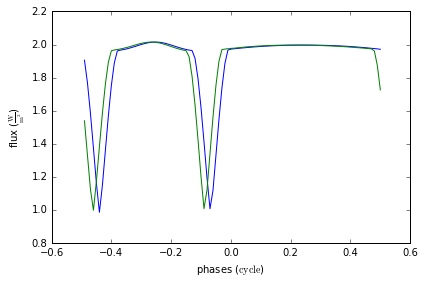

In [10]:
axs, artists = b['lc01@model'].plot(x='phases')
axs, artists = b['lc02@model'].plot(x='phases')

Influence on ETVs (timings)
----------------

The eclipses getting closer to each other in phase-space should then also show in the ETVs

In [12]:
#axs, artists = b['etv01@model'].plot()